<h3><center>Introduction to building a quant pricing library</center></h3>
<h1><center>Building Blocks of the Framework</center></h1>
<h3><center>Gabor Friedmann</center></h3>
<h4><center>2 October, 2024</center></h4>

## What did we learn last time?

<b>Risk-free interest rate</b> ($r$): Annual return of a riskless investment, i.e. the minimum return an investor expects for any investment.

<b>Spot contract</b>: An agreement between two parties (a buyer and a seller) to trade an asset "*immediately*".

Fair value: $ S_t $

The buyer of a contract takes a *Long* position, while the seller of a contract takes a *Short* position.

<b>Forward contract</b>: An agreement between two parties (a buyer and a seller) to trade an underlying asset at a <u>certain price</u> ($K$: strike) on a <u>certain future date</u> ($T$: expiry). This is an <u>obligation</u> to both parties.

Payoff at expiry (LF): $ \;\;\; S_T-K $

<img src="./img/payoff_forward.jpg" style="margin-left:auto; margin-right:auto; width: 730px;" />

<b>(European) Call option contract</b>: The option buyer has the <u>right</u>, but not the obligation, to <u><b>buy</b></u> an underlying asset at a certain price ($K$: strike) on a certain future date ($T$: expiry). If option is exercised by buyer, the option seller must <u>sell</u> the underlying asset.

Payoff at expiry (LC): $ \;\;\; max\lbrace S_T-K, 0\rbrace $

<img src="./img/payoff_call.jpg" style="margin-left:auto; margin-right:auto; width: 730px;" />

<b>(European) Put option contract</b>: The option buyer has the <u>right</u>, but not the obligation, to <u><b>sell</b></u> an underlying asset at a certain price ($K$: strike) on a certain future date ($T$: expiry). If option is exercised by the option buyer, the option seller must <u>buy</u> the underlying asset.

Payoff at expiry (LP): $ \;\;\; max\lbrace K-S_T, 0\rbrace $

<img src="./img/payoff_put.jpg" style="margin-left:auto; margin-right:auto; width: 730px;" />

## Pricing under Black-Scholes model assumptions
Spot price: $ S_t $, strike price: $ K $, expiry: $ T $, volatility of underlying: $ \sigma $, risk-free rate: $ r $

<b>Forward (LF)</b>: $ \;\;\; f_t = S_t - Ke^{-r(T-t)} $

<b>Call option (LC)</b>: $ \;\;\; c_t = S_tN(d_1) - Ke^{-r(T-t)}N(d_2) $

<b>Put option (LP)</b>: $ \;\;\; p_t = Ke^{-r(T-t)}N(-d_2) - S_tN(-d_1) $

where $N(\cdot)$ is the standard normal CDF

$ d_1 = \dfrac{1}{\sigma\sqrt{T-t}}\left[ln\left(\dfrac{S_t}{K}\right)+\left(r+\dfrac{\sigma^2}{2}\right)(T-t)\right] \;\;\;\;\;\;\;\;\;\; d_2 = d_1 - \sigma\sqrt{T-t} $

<br>
<b>Put-call parity</b>: $ LF=LC+SP $

$ f_t=c_t-p_t $

## Warm up exercise

Let's price a real life European call option contract on a Google stock using Black-Scholes model.

Data:

* https://finance.yahoo.com/quote/GOOG/options?p=GOOG
* https://www.marketwatch.com/investing/bond/tmubmusd01y

<img src="./img/pricing_example.jpg" style="margin-left:auto; margin-right:auto" />

In [1]:
import numpy as np
from scipy.stats import norm

def black_scholes_european_call(S0: float, K: float, T: float, sigma: float, r: float):
    d1 = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2 = d1 - sigma * T**0.5
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    df = np.exp((-1.0)*r*T)
    return S0 * N_d1 - K * df * N_d2

In [2]:
import pandas as pd

df = pd.read_csv('GOOG.csv', usecols=['Date', 'Close'], index_col='Date')
df['CloseTM1'] = df['Close'].shift(1)
df['LogReturn'] = np.log(df['Close'] / df['CloseTM1'])

daily_log_return_std = np.std(df['LogReturn'], ddof=1)
# Annualization: ~260 weekdays per year
volatility = daily_log_return_std * np.sqrt(260)

print(f'Historical volatility: {round(volatility*100, 2)}%')

Historical volatility: 36.15%


In [3]:
import datetime as dt

today = dt.date(2023, 8, 14)

spot = 129.43
strike = 125
expiry = (dt.date(2024,9,20) - today).days / 365
vol = 0.3615
rate = 0.05372

premium = black_scholes_european_call(spot, strike, expiry, vol, rate)
print(f'Premium: {round(premium, 2)}$')

Premium: 25.0$


## How to build a pricing library?

<b>Goal</b>: Implement a coherent code base that is able to calculate fair value and greeks of various contracts in a generic way.

<b>Requirements</b>:
* Separate market data from pricing code
* Reusability: Avoid code duplication
* Scalability: Should be fairly easy to onboard a new contract or a pricer
* Encapsulation: Bundle related data and funcionalities into a structured unit

<img src="./img/building_blocks_empty.jpg" style="margin-left:auto; margin-right:auto; width: 1000px;" />

<img src="./img/building_blocks_full.jpg" style="margin-left:auto; margin-right:auto; width: 1000px;" />

<img src="./img/contracts.jpg" style="margin-left:auto; margin-right:auto; width: 800px;" />

## Important concepts

<b>Inheritance</b>: Deriving a class (Derived/Child/Sub) from another class (Base/Parent/Super) that share a set of properties and methods.

<b>Abstract Base Class (ABC)</b>: Such a class is not concrete and cannot be instantiated. Instead, it forces derived classes to implement all abstract properties and methods.


In [4]:
from abc import ABC, abstractmethod

# Abstract base class (ABC): cannot be instantiated
class Shape(ABC):
    # Abstract method: all subclasses must implement it
    @abstractmethod
    def perimeter(self):
        pass
    
    # Subclasses will inherit this method
    def class_name(self):
        return type(self).__name__

# Subclass
class Rectangle(Shape):
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def perimeter(self):
        return 2 * (self.a + self.b)

# Subclass
class Triangle(Shape):
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def perimeter(self):
        return self.a + self.b + self.c

In [5]:
tri = Triangle(2, 3, 4)
print(tri.class_name())
print(f'Perimeter: {tri.perimeter()}')

print('')

rec = Rectangle(5, 8)
print(rec.class_name())
print(f'Perimeter: {rec.perimeter()}')

Triangle
Perimeter: 9

Rectangle
Perimeter: 26


<b>Let's build the library!</b>

# Tasks

## MarketData - market_data.py

* Define the necessary market data (spot, volatility, risk-free rate) in MarketData class.


| Risk-free rate |
| :-: |
| 0.05 |


| Underlying | Spot | Volatility |
| :- | :-: | :-: |
| Stock.BLUECHIP_BANK | 130.17 | 0.381 |
| Stock.TIPTOP_SOLUTIONS | 177.32 | 0.320 |


## Market Model - model.py

* Define MarketModel class.
* Define its __init__() method:
    * Take an underlying Stock as input.
    * Store the underlying and the corresponding market data (risk-free rate, spot, volatility).
* Implement calc_df() method which takes a tenor and returns the corresponding discount factor.


## Contract - contract.py

* Implement payoff() methods in derived classes
* Make it compulsory to implement these methods for future enhancements

## Pricer - pricer.py

* Implement calc_fair_value() method in ForwardAnalyticPricer.
* Implement calc_fair_value() method in EuropeanAnalyticPricer.


## Test - test_pricer.py

* Create put-call parity test for fair value and all greeks using various underlying, strike, expiry.

# Assignments - Digital options

1. Get familiar with digital options and implement EuropeanDigitalContract and EuropeanDigitalAnalyticPricer (fair value and greeks) in the library (src folder).
Implement unit test for fair value using pytest (test folder). **(12 points)**
2. Get familiar with bull spread options and by utilizing EuropeanDigitalAnalyticPricer and EuropeanAnalyticPricer,
create a figure to visualize that a digital call option can be thought of as a limit of bull spread call options. **(8 points)**

## Suggestion

Create a new branch for your assigment where you can save (commit) your changes.

<code>git checkout -b name_of_your_branch</code><br>
...do your changes...<br>
<code>git add</code><br>
<code>git commit</code>


Once you are done, get back to master branch:

<code>git checkout master</code>

In [6]:
# Add current folder and QuantCourseBP folder to syspath to import modules
import sys
from pathlib import Path
current = Path(Path().resolve())
sys.path.append(str(current))
sys.path.append(str(current.parents[2]))

In [7]:
from src.enums import *
from src.pricer import *
from src.contract import *

In [8]:

class MarketModel:
    def __init__(self, underlying: Stock):
        self.underlying = underlying
        self.risk_free_rate = MarketData.get_risk_free_rate()
        self.spot = MarketData.get_spot()[self.underlying]
        self.vol = MarketData.get_vol()[self_underlying]

    def calc_df(self, tenor: float) -> float:
        return np.exp(-self.risk_free_rate * tenor)


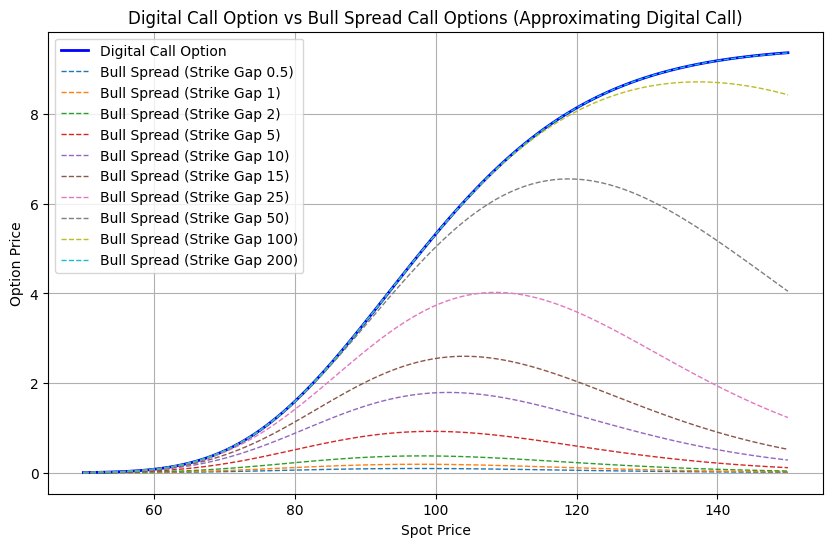

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
strike_price_digital = 100.0
maturity = 1.0  # 1 year
payout = 10.0
spot_prices = np.linspace(50, 150, 100)  # Wider range of spot prices
volatility = 0.2
interest_rate = 0.05

# Digital call option and pricer
digital_contract_call = EuropeanDigitalContract(strike_price_digital, maturity, payout, "call")
digital_pricer_call = EuropeanDigitalAnalyticPricer(digital_contract_call, spot_prices[0], volatility, interest_rate)

# Prepare lists to store prices
digital_call_prices = []
bull_spread_prices = {0.5: [], 1: [], 2: [],  5: [], 10: [], 15: [], 25: [], 50: [],  100: [],  200: []}  # Smaller strike gaps to approximate digital call more closely

# Loop over spot prices
for S in spot_prices:
    # Digital call option price
    digital_pricer_call.spot = S
    digital_call_prices.append(digital_pricer_call.price())

    # Calculate bull spread prices with decreasing strike gaps (0.5, 1, 2)
    for gap in bull_spread_prices.keys():
        strike_price_1 = strike_price_digital
        strike_price_2 = strike_price_digital + gap
        
        # Define two call options for the bull spread
        bull_spread_contract_1 = EuropeanDigitalContract(strike_price_1, maturity, payout, "call")
        bull_spread_contract_2 = EuropeanDigitalContract(strike_price_2, maturity, payout, "call")

        # Pricers for the bull spread options
        bull_spread_pricer_1 = EuropeanDigitalAnalyticPricer(bull_spread_contract_1, S, volatility, interest_rate)
        bull_spread_pricer_2 = EuropeanDigitalAnalyticPricer(bull_spread_contract_2, S, volatility, interest_rate)
        
        # Bull spread price: long call at strike 1, short call at strike 2
        bull_spread_price = bull_spread_pricer_1.price() - bull_spread_pricer_2.price()
        bull_spread_prices[gap].append(bull_spread_price)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(spot_prices, digital_call_prices, label='Digital Call Option', color='blue', linewidth=2)
for gap, prices in bull_spread_prices.items():
    plt.plot(spot_prices, prices, linestyle='--', label=f'Bull Spread (Strike Gap {gap})', linewidth=1)
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.title('Digital Call Option vs Bull Spread Call Options (Approximating Digital Call)')
plt.legend()
plt.grid(True)
plt.show()
